# Instacart
- Start date: 14March2018
- End date: End of May
- Learning objectives:
    - Understand the workflow process of Data Science
    - Become more familiar with using Clustering analytic approaches
    - Apply crisp-dm to problem solving
    - Solving current real world problems involving product prediction and recommendation 
    https://www.kaggle.com/c/instacart-market-basket-analysis

The below steps are based on CRISP-DM:

### Step 1: Business understanding
Predict which products will be in the user's next order. The submission file will contain the order_id, and product ids. 

### Step 2: Analytic approach exploration 
- We will create new features from existing data
- We will use XGboost on the training data set to predict the probability a single item will be in the user's next order 
- We will then combine the items into a single order which is the 'next order' of the user; this will become the submission file

### Step 3: Data requirements 
All data is provided, no additional data can be garnered unless we do feature engineering

### Step 4: Data collection
All data is provided. 

### Step 5. Data understanding
- Find out what data is provided
- What type is it? 
- How many values are there? etc... 

In [1]:
# import all files (total of 6), and models that will be used to visualize the data and run the model in later steps

import numpy as np
import pandas as pd
from sklearn.cluster import k_means
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')
previous_orders_prior = pd.read_csv('order_products__prior.csv')
previous_orders_train = pd.read_csv('order_products__train.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')

In [4]:
# file 1: aisles

In [2]:
aisles.head(3)

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars


In [3]:
aisles.dtypes

aisle_id     int64
aisle       object
dtype: object

In [4]:
# number of aisles
len(aisles)

134

In [73]:
# file 2: products 

In [5]:
products.head(3)

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7


In [6]:
products.dtypes

product_id        int64
product_name     object
aisle_id          int64
department_id     int64
dtype: object

In [7]:
# number of products
len(products)

49688

In [8]:
# number of departments; there are 21 departments in total
set(products.department_id)

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}

In [82]:
# file 3: orders

In [9]:
orders.head(3)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0


In [10]:
orders.dtypes

order_id                    int64
user_id                     int64
eval_set                   object
order_number                int64
order_dow                   int64
order_hour_of_day           int64
days_since_prior_order    float64
dtype: object

In [11]:
# total number of orders
len(orders)

3421083

In [12]:
# total number of user_ids
len(set(orders.user_id))

206209

In [13]:
# shows all the data in eval_set
set(orders.eval_set)

{'prior', 'test', 'train'}

In [89]:
# number of orders in prior set
len(orders[orders['eval_set']== 'prior'])

3214874

In [90]:
# number of orders in test set
len(orders[orders['eval_set']== 'test'])

75000

In [91]:
# number of orders in train set
len(orders[orders['eval_set']== 'train'])

131209

In [14]:
# maximum number of orders per user; the number of orders per user can range from 1 - 100
len(set(orders.order_number))

100

In [15]:
# shows the data in order_dow; we can concur that these represent 7 days of the week.
set(orders.order_dow)

{0, 1, 2, 3, 4, 5, 6}

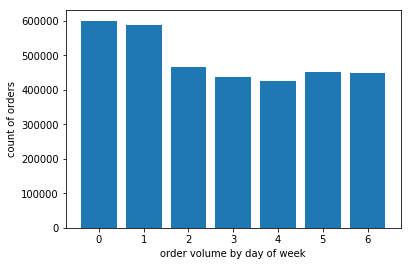

In [94]:
# Plot the orders data to see the volume of orders by day of week (dow). Define your x, and y axes
# More orders are made on days 0, 1 
df_dow = orders.groupby('order_dow').agg({'order_id': 'count'})
x = df_dow.index
y = df_dow.order_id

plt.bar(x,y)
plt.xlabel('order volume by day of week')
plt.ylabel('count of orders')
plt.show()

In [16]:
# shows the data in order_hour_of_day; hours range from 0 - 23 
len(set(orders.order_hour_of_day))

24

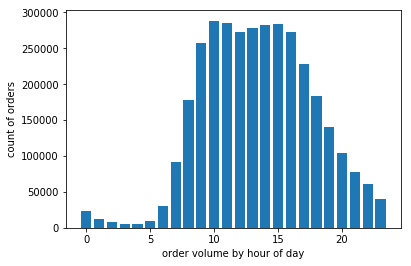

In [92]:
# Plot the orders data to see the volume of orders by hour of day (hod). Define your x, and y axes
df_hod = orders.groupby('order_hour_of_day').agg({'order_id': 'count'})
x = df_hod.index
y = df_hod.order_id

plt.bar(x,y)
plt.xlabel('order volume by hour of day')
plt.ylabel('count of orders')
plt.show()

In [107]:
# show a sample of all orders from a unique user_id
orders[orders['user_id']==112108]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
1868041,1427983,112108,prior,1,1,14,NaN
1868042,2541372,112108,prior,2,1,10,7.0
1868043,186706,112108,prior,3,2,21,15.0
1868044,1,112108,train,4,4,10,9.0


In [108]:
# counts the total number of orders for a user_id
len(orders[orders['user_id']==112108])

4

In [86]:
# shows the count, min, max, mean, and median values of a days since prior order grouped by user_id
# count does not include NaN so user_id 1 should have total of 11 orders, not 10
orderstatistics_per_user = orders.groupby('user_id').agg({'days_since_prior_order': ['count', 'min', 'max', 'mean', 'median']})
orderstatistics_per_user.head(3)

days_since_prior_order                             
                         count  min   max       mean median
user_id                                                    
1                           10  0.0  30.0  19.000000   19.5
2                           14  3.0  30.0  16.285714   13.0
3                           12  7.0  21.0  12.000000   11.0

In [85]:
#make index become label (drops 'days_since_prior_order' from table above)
orderstatistics_per_user.reset_index() 
orderstatistics_per_user.head(3)

days_since_prior_order                             
                         count  min   max       mean median
user_id                                                    
1                           10  0.0  30.0  19.000000   19.5
2                           14  3.0  30.0  16.285714   13.0
3                           12  7.0  21.0  12.000000   11.0

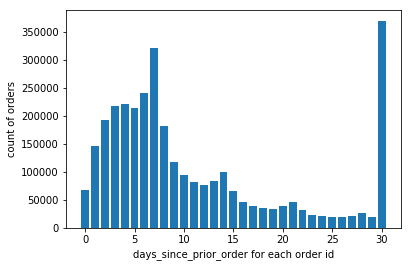

In [84]:
# Plot the orders data to see the frequency of reorders. Define your x, and y axes
df = orders.groupby('days_since_prior_order').agg({'order_id': 'count'})
x = df.index
y = df.order_id

plt.bar(x,y)
plt.xlabel('days_since_prior_order for each order id')
plt.ylabel('count of orders')
plt.show()

In [33]:
# file 4: order_products_train

In [37]:
previous_orders_prior.head(3)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0


In [38]:
previous_orders_prior.dtypes

order_id             int64
product_id           int64
add_to_cart_order    int64
reordered            int64
dtype: object

In [46]:
# shows the unique number of order_ids in this data set
len(set(previous_orders_prior.order_id))

3214874

In [41]:
# shows the total number of items added to a basket, and the order in which the item was added. 
# The order ranges from 1-145
len(set(previous_orders_prior.add_to_cart_order))

145

In [42]:
# shows if a product_id was reordered or not 
set(previous_orders_prior.reordered)

{0, 1}

In [56]:
# file 5: order_products_train

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0


In [44]:
previous_orders_train.head(3)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0


In [47]:
len(set(previous_orders_train.order_id))

131209

In [45]:
# file 6: department

,department_id,department
0,1,frozen
1,2,other
2,3,bakery


In [48]:
departments.head(3)

,department_id,department
0,1,frozen
1,2,other
2,3,bakery


In [49]:
departments.dtypes

department_id     int64
department       object
dtype: object

In [50]:
len(departments.department_id)

21

In [103]:
# Now combine the dataframes previous_orders_train (pot) & orders to get the product_ids for each order_id in the training set
df_pot_orders = pd.merge(previous_orders_train, orders, how='left', on='order_id')
df_pot_orders_prod = pd.merge(df_pot_orders, products, how='left', on='product_id')
df_pot_orders_prod_dep = pd.merge(df_pot_orders_prod, departments, how='left', on='department_id')
df_pot_orders_prod_dep.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,department
0,1,49302,1,1,112108,train,4,4,10,9.0,Bulgarian Yogurt,120,16,dairy eggs
1,1,11109,2,1,112108,train,4,4,10,9.0,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,dairy eggs
2,1,10246,3,0,112108,train,4,4,10,9.0,Organic Celery Hearts,83,4,produce
3,1,49683,4,0,112108,train,4,4,10,9.0,Cucumber Kirby,83,4,produce
4,1,43633,5,1,112108,train,4,4,10,9.0,Lightly Smoked Sardines in Olive Oil,95,15,canned goods


In [104]:
# check to see if the new data frame contains the same number of order ids as we expect in the previous_orders_train
len(set(df_pot_orders_prod_dep.order_id))

131209

### Data Transformation

In short, everything of data manipulation will be here, including feature engineering and data cleaning. The below cell will be revisited many times and served as the main reference for any data used later on.

- define numerical values of correlations in the product_id being reordered and other data in the new dataframe.

examples: 
probability reordered based on hod;
probability reordered based on dow;
probability reordered based on days since prior order; 
probability reordered based on add to cart; 
probability reordered based on department

In [109]:
(df_pot_orders_prod_dep[['user_id', 'order_id', 'product_id', 'reordered', 'order_number']]
[df_pot_orders_prod_dep['user_id'] == 112108])

,user_id,order_id,product_id,reordered,order_number
0,112108,1,49302,1,4
1,112108,1,11109,1,4
2,112108,1,10246,0,4
3,112108,1,49683,0,4
4,112108,1,43633,1,4
5,112108,1,13176,0,4
6,112108,1,47209,0,4
7,112108,1,22035,1,4


In [19]:
# """
# An class to transform data, including all necessary methods
# """

# class dataTransformation:
#  """
#     """
#     def __init__(self, wreck_train):
#         self.wreck_train = wreck_train.copy()
#     def lower_case_column(self):
#         self.wreck_train.columns = map(str.lower, wreck_train.columns)
#     def lower_case_sirname(self):
#         self.wreck_train['sirname'] = self.wreck_train['name'].apply(lambda x: x.split(',')[0])
#     def lower_case_title(self):    
#         self.wreck_train['title']   = self.wreck_train['name'].apply(lambda x: x.split(',')[1]\
#                                                                 .split('.')[0]\
#                                                                 .strip())
#     def fill_na_cabin(self):
#         self.wreck_train['cabin'].fillna('', inplace=True)
#     def fill_na_cabin_type(self):
#         self.wreck_train['cabin_type'] = self.wreck_train['cabin']\
#                                         .apply(lambda x: x[0] if x != '' else x)
#     def get_num_ticket_sharer(self):
#         self.wreck_train['num_ticket_sharer'] = (self.wreck_train\
#                                                  .groupby(by=['ticket'])['passengerid']\
#                                                  .transform('count'))
        
#     def get_num_family_by_name(self):
#         self.wreck_train['num_family_member'] = (self.wreck_train
#                                                  .groupby(by=['ticket','sirname'])['passengerid']
#                                                  .transform('count'))-1
        
#     def get_num_family_member_2(self):
#         self.wreck_train['num_family_member_2'] = self.wreck_train['sibsp'] + wreck_train['parch']
#     def turn_pclass_string(self):
#         self.wreck_train['pclass'] = self.wreck_train['pclass'].astype(str)
        
        

### Simple model (naive model)

This model will be served as a baseline to help us compare between different results. 

First, initialize a model with two lines

In [4]:
from sklearn.linear_model import LinearRegression

baseline_model = LinearRegression()

### Dumify the product_id in order to put into a linear regression model

In [12]:
dummy = pd.get_dummies(combined_baseline_file[["product_id"]])

NameError: name 'combined_baseline_file' is not defined

In [ ]:
dummy

In [6]:
for elem in combined_baseline_file["product_id"][:10].unique():
    combined_baseline_file[str(elem)] = combined_baseline_file["product_id"] == elem

In [7]:
combined_baseline_file.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,...,49302,11109,10246,49683,43633,13176,47209,22035,39612,19660
0,1,49302,1,1,112108,train,4,4,10,9.0,...,True,False,False,False,False,False,False,False,False,False
1,1,11109,2,1,112108,train,4,4,10,9.0,...,False,True,False,False,False,False,False,False,False,False
2,1,10246,3,0,112108,train,4,4,10,9.0,...,False,False,True,False,False,False,False,False,False,False
3,1,49683,4,0,112108,train,4,4,10,9.0,...,False,False,False,True,False,False,False,False,False,False
4,1,43633,5,1,112108,train,4,4,10,9.0,...,False,False,False,False,True,False,False,False,False,False


In [9]:
baseline_data = combined_baseline_file[["order_id","49302","11109"]]

In [11]:
###  this is where we stopped 


In [10]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(baseline_model, baseline_data, predictions, scoring = "accuracy", cv=10, n_jobs = 2)


NameError: name 'predictions' is not defined

In [23]:
transformed_data = dataTransformation(wreck_train)
transformed_data.lower_case_column()

#### 1. Cleaning data (for existent data)

In [26]:
transformed_data.lower_case_sirname()
transformed_data.turn_pclass_string()
transformed_data.fill_na_cabin()
transformed_data.fill_na_cabin_type
transformed_data.wreck_train.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 891 entries, 0 to 890

Data columns (total 13 columns):

passengerid    891 non-null int64

survived       891 non-null int64

pclass         891 non-null object

name           891 non-null object

sex            891 non-null object

age            714 non-null float64

sibsp          891 non-null int64

parch          891 non-null int64

ticket         891 non-null object

fare           891 non-null float64

cabin          891 non-null object

embarked       889 non-null object

sirname        891 non-null object

dtypes: float64(2), int64(4), object(7)

memory usage: 90.6+ KB


In [54]:
transformed_data.wreck_train.groupby('cabin')['passengerid'].count().sort_values(ascending=False)

cabin

                   687

C23 C25 C27          4

B96 B98              4

G6                   4

F33                  3

F2                   3

E101                 3

C22 C26              3

D                    3

B49                  2

B51 B53 B55          2

D17                  2

B5                   2

D20                  2

D35                  2

D26                  2

C124                 2

D36                  2

B35                  2

B57 B59 B63 B66      2

C92                  2

B58 B60              2

C93                  2

B22                  2

B77                  2

C83                  2

C78                  2

C68                  2

C65                  2

C52                  2

                  ... 

D47                  1

D45                  1

C148                 1

D37                  1

C30                  1

C32                  1

C45                  1

C46                  1

C47                  1

C49                  1

C50      

In [58]:
transformed_data.wreck_train.groupby('cabin')['passengerid'].count().hist?

Docstring: Alias for `%history`.

File:      ~/anaconda3/envs/Titanic/lib/python3.5/site-packages/IPython/core/magic.py


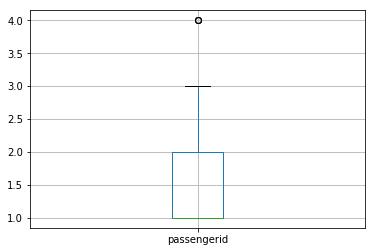

In [75]:
pd.DataFrame(transformed_data.wreck_train.groupby('cabin')['passengerid'].count()[1:]).boxplot()

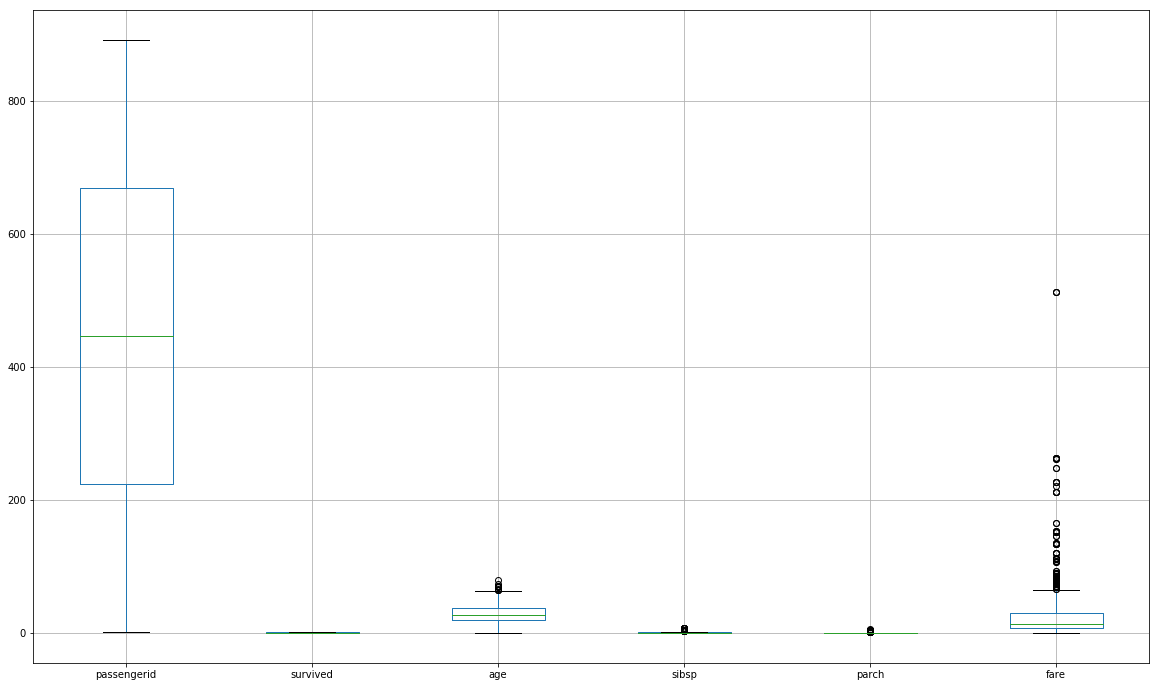

In [79]:
transformed_data.wreck_train.boxplot(figsize=(20,12))

#### 2. Data manipulation (for new data)

In [43]:
variables_of_choice = ['sex','pclass','cabin']
dummies = transformed_data.wreck_train[variables_of_choice].fillna(0)
dummies = pd.get_dummies(dummies)

In [44]:
dummies.head(5)

,sex_female,sex_male,pclass_1,pclass_2,pclass_3,cabin_,cabin_A10,cabin_A14,cabin_A16,cabin_A19,...,cabin_E8,cabin_F E69,cabin_F G63,cabin_F G73,cabin_F2,cabin_F33,cabin_F38,cabin_F4,cabin_G6,cabin_T
0,0,1,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 3. See how a model is improve

In [45]:
scores = cross_val_score(baseline_model, dummies , predictions, scoring = "accuracy", cv=10, n_jobs = 2)

print("Baseline model with {} feature ({}) is {:0.7} %".format(len(variables_of_choice), \
                                                                variables_of_choice, \
                                                                np.mean(scores) * 100))

Baseline model with 3 feature (['sex', 'pclass', 'cabin']) is 79.23037 %


Well, we have seen an improvement here! The only thing I am concerning is about `78.6698%`. 

In [46]:
scores

array([0.82222222, 0.78888889, 0.7752809 , 0.82022472, 0.82022472,

       0.78651685, 0.7752809 , 0.75280899, 0.82022472, 0.76136364])

### Machine Learning approach with Grid Search

I would never ever recommend this approach in practice because of a lack of intepretability and expensivity of computing. Though machine learning is very appealing, this should only applied when you have so much data and well-defined workflow with a good framing problem. The belows are only for demonstration of how most of machine learning praticioner would do. The first candidate to be introduced is `Grid Search` along with its bros and sis, e.g. `Random Search`, `Lasso Search`, `Beam Search`, etc.

Let us learn to read documentation supported by `Scikit-learn` for more details

In [1]:
from sklearn.model_selection import GridSearchCV
GridSearchCV?

Init signature: GridSearchCV(estimator, param_grid, scoring=None, fit_params=None, n_jobs=1, iid=True, refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs', error_score='raise', return_train_score='warn')

Docstring:     

Exhaustive search over specified parameter values for an estimator.



Important members are fit, predict.



GridSearchCV implements a "fit" and a "score" method.

It also implements "predict", "predict_proba", "decision_function",

"transform" and "inverse_transform" if they are implemented in the

estimator used.



The parameters of the estimator used to apply these methods are optimized

by cross-validated grid-search over a parameter grid.



Read more in the :ref:`User Guide <grid_search>`.



Parameters

----------

estimator : estimator object.

    This is assumed to implement the scikit-learn estimator interface.

    Either estimator needs to provide a ``score`` function,

    or ``scoring`` must be passed.



param_grid : dict or list of dictionaries


Here is an exmaple to plug-and-play in our dataset

In [48]:
parameters = {'C': [0.1, 0.5, 1, 5, 10, 50, 100]}
clf = GridSearchCV(LogisticRegression(), parameters, scoring="accuracy")
clf.fit(dummies, predictions)
pd.DataFrame(clf.cv_results_)

/home/emma/anaconda3/envs/Titanic/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True

  warnings.warn(*warn_args, **warn_kwargs)

/home/emma/anaconda3/envs/Titanic/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True

  warnings.warn(*warn_args, **warn_kwargs)

/home/emma/anaconda3/envs/Titanic/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True

  warnings.warn(*warn_args, **warn_kwa

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.004271,0.000754,0.786756,0.786756,0.1,{'C': 0.1},3,0.787879,0.786195,0.801347,0.779461,0.771044,0.794613,0.000521,0.000039,0.012397,0.006198
1,0.004571,0.001059,0.790123,0.818743,0.5,{'C': 0.5},2,0.791246,0.836700,0.808081,0.824916,0.771044,0.794613,0.001202,0.000682,0.015141,0.017728
2,0.002848,0.000501,0.791246,0.825477,1,{'C': 1},1,0.791246,0.838384,0.808081,0.826599,0.774411,0.811448,0.000068,0.000042,0.013746,0.011025
3,0.003132,0.000531,0.764310,0.837823,5,{'C': 5},5,0.747475,0.846801,0.771044,0.833333,0.774411,0.833333,0.000112,0.000052,0.011983,0.006349
4,0.003886,0.000602,0.765432,0.838384,10,{'C': 10},4,0.750842,0.846801,0.771044,0.835017,0.774411,0.833333,0.000719,0.000109,0.010408,0.005992
5,0.003486,0.000475,0.759820,0.839506,50,{'C': 50},7,0.744108,0.846801,0.760943,0.835017,0.774411,0.836700,0.000292,0.000058,0.012397,0.005204
6,0.003559,0.000490,0.760943,0.839506,100,{'C': 100},6,0.747475,0.846801,0.760943,0.835017,0.774411,0.836700,0.000178,0.000087,0.010997,0.005204


### XG Boost vs Random forest

XG Boost 



In [49]:
import xgboost as xgb

xg_model = xgb.XGBClassifier()
scores = cross_val_score(xg_model, dummies , predictions, scoring = "accuracy", cv=10, n_jobs = 2)
print("Baseline model with {} feature ({}) is {:0.10} %".format(len(variables_of_choice), \
                                                                variables_of_choice, \
                                                                np.mean(scores) * 100))

/home/emma/anaconda3/envs/Titanic/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

  if diff:

/home/emma/anaconda3/envs/Titanic/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

  if diff:

/home/emma/anaconda3/envs/Titanic/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

  if diff:

/home/emma/anaconda3/envs/Titanic/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: Deprecat

Baseline model with 3 feature (['sex', 'pclass', 'cabin']) is 77.66607082 %


In [50]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
scores = cross_val_score(xg_model, dummies , predictions, scoring = "accuracy", cv=10, n_jobs = 2)
print("Baseline model with {} feature ({}) is {:0.10} %".format(len(variables_of_choice), \
                                                                variables_of_choice, \
                                                                np.mean(scores) * 100))

/home/emma/anaconda3/envs/Titanic/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

  if diff:

/home/emma/anaconda3/envs/Titanic/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

  if diff:

/home/emma/anaconda3/envs/Titanic/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

  if diff:

/home/emma/anaconda3/envs/Titanic/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: Deprecat

Baseline model with 3 feature (['sex', 'pclass', 'cabin']) is 77.66607082 %


### Issues:

- Overfitting/ Underfitting
- Variance/ bias


### To take-away for machine learners:
- More data is always better, better models
- Bigger models is always better
- Most of work can be automated with `python`. 